## Modelling - Logistic Regression
Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification.
It is easy to implement and can be used as the baseline for any binary classification problem.
Its basic fundamental concepts are also constructive in deep learning. Logistic regression describes and estimates the
relationship between one dependent binary variable and independent variables.

#### Predict variable (desired target):

`y` —  In general, your health is …? (`Health_condition`)

The health column of the dataset has many categories and we need to reduce the categories for a better modelling.
The health column has the following categories:

In [6]:
# installing required packages
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
root_data_path = Path("data")
eqls_path = Path(str(root_data_path)+"/derived_data/eqls_2011_described.csv").resolve()
eqls_2011_df_target_nona = pd.read_csv(eqls_path)

eqls_2011_df_target_nona.head()

eqls_2011_df_target_nona['Health_condition'].unique()

array([ 1.,  3.,  4.,  2.,  5., nan])

The labels in our current target variable are as follows:
- `"1"` (Label = Very good)
- `"2"` (Label = Good)
- `"3"` (Label = Fair)
- `"4"` (Label = Bad)
- `"5"` (Label = Very bad) together.

Let's create an updated variable that is binary (i.e. either a 1 or a 0 such that `"1"`, means “Good”, `"0"` means “Bad”).
Lets assign the `"1"`, `"2"`, `"3"` to the value `"1"`, and likewise, `"4"` and `"5"` to the value of `"0"`.

In [9]:
eqls_2011_df_target_nona['Health_condition_binary'] = eqls_2011_df_target_nona.Health_condition.apply(lambda x: 1 if float(x) <= 3 else 0)

In [10]:
eqls_2011_df_target_nona[['Health_condition_binary','Health_condition']].head()

,Health_condition_binary,Health_condition
0,1,1.0
1,1,1.0
2,1,3.0
3,1,1.0
4,1,1.0


We can see that the column `Health_condition_binary` contains `1` where the value is `[1, 2, 3]` in the column `Health_condition`.

In [13]:
# dropping the ID's which are not predictor variables
feature_2011_columns = eqls_2011_df_target_nona.drop(columns=['RowID_for_the_UK_Data_service_Public_API',
                                                              'Root_URI_for_a_row_respondent_that_displays_all_data_values_for_a_single_row_via_the_UK_Data_Service_Public_API',
                                                              'Unique_respondent_ID'])

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

eqls_2011_target = feature_2011_columns.Health_condition_binary
eqls_2011_predictors = feature_2011_columns.drop(['Health_condition_binary','Health_condition'], axis=1)

# For the sake of keeping the example simple, we'll use only numeric predictors.
eqls_2011_numeric_predictors = eqls_2011_predictors.select_dtypes(exclude=['object'])

X_train, X_test, y_train, y_test = train_test_split(eqls_2011_numeric_predictors,
                                                    eqls_2011_target,
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=0)

def logistic_regression_score_dataset(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

We remove the columns `'Health_condition'` as our new target variable (`Health_condition_binary`) are derived from this
Lets compare the results with the different imputation methods illustrated earlier.

In [16]:
cols_with_missing = [col for col in X_train.columns
                                 if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_test  = X_test.drop(cols_with_missing, axis=1)
print("Mean Absolute Error from dropping columns with Missing Values:")
print(logistic_regression_score_dataset(reduced_X_train, reduced_X_test, y_train, y_test))

Mean Absolute Error from dropping columns with Missing Values:
0.10899457550145074


#### Get Logistic Regression Score from Imputation


In [19]:

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


imputed_X_train = DataFrameImputer().fit_transform(X_train)
imputed_X_test = DataFrameImputer().fit_transform(X_test)
print("Mean Absolute Error from Imputation:")
print(logistic_regression_score_dataset(imputed_X_train, imputed_X_test, y_train, y_test))


Mean Absolute Error from Imputation:
0.08002186619570245


/Users/clast/Documents/2021_projects/rds-course/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We can see that the imputation significantly improves the result of the logistic regression.
We can diagnose our results using a Confusion Matrix.

A confusion matrix is a table that is used to evaluate the performance of a classification model. You can also visualize the performance of an algorithm.
The fundamental of a confusion matrix is the number of correct and incorrect predictions are summed up class-wise.

In [20]:
# import the metrics class
from sklearn import metrics

def get_prediction(X_train, X_test, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return preds

y_pred = get_prediction(imputed_X_train, imputed_X_test, y_train)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

/Users/clast/Documents/2021_projects/rds-course/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[ 1189,  1403],
       [  500, 20689]])

Here, you can see the confusion matrix in the form of the array object.
The dimension of this matrix is 2*2 because this model is binary classification.
You have two classes 0 representing "poor health" and 1, representing "good health".
Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions.

In the output, `44` and `571` are actual predictions (`44` is the number of true "poor health" predictions, and `571` is the number of ture "good health" predictions).
`34` and `27` are incorrect predictions (`34` is the number of "poor health" predictions predicted incorrectly as "good health",
and `310` is the number of false "good health" predictions).


<div class="alert alert-block alert-warning"> This model overly predicts "good health" outcomes, and may benefit from oversampling
surveyed respondents which self-report "poor health". </code> </div>

Accuracy: 0.9199781338042975
Precision: 0.9364928480898063
Recall: 0.9764028505356553


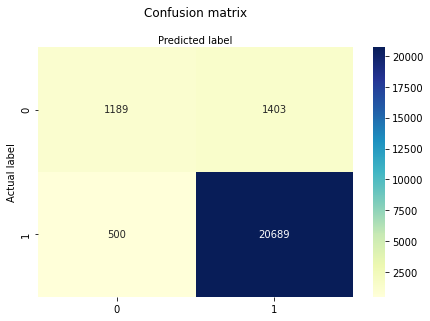

In [21]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [40]:
feature_2011_columns.to_csv(str(root_data_path)+f"/derived_data/eqls_2011_modelled.csv")
for name, df in {"imputed_X_train": imputed_X_train,
                 "imputed_X_test": imputed_X_test,
                 "y_train": y_train,
                 "y_test": y_test}.items():
    df.to_csv(str(root_data_path)+f"/derived_data/eqls_2011_{name}.csv", index=False)

In [41]:
# save numpy array as csv file
from numpy import savetxt
savetxt(str(root_data_path)+f"/derived_data/y_pred.csv", y_pred, delimiter=",")